In [1]:
import pylab
import numpy as np
import nest

## Experiment 1
- 3 HH neurons
- reciprocal delayed synaptic connections
- intracellular constant current stimulation of $10 \frac{\mu A}{cm^2}$
- random inital phase

![alt text](img/exp1.png "Experiment 1")

### Configuration following Materials and Methods SI

$C = 1 \frac{\mu F}{cm^2}$

$g_{Na} = 120 \frac{mS}{cm^2}, g_K = 36 \frac{mS}{cm^2}, g_L = 0.3 \frac{mS}{cm^2}$

$E_{Na} = 50 mV, E_K = -77 mV, E_L = -54.5 mV$

$\tau_r = \tau_{ex} = 0.1 ms, \tau_d = \tau_{in} = 3 ms$

In [2]:
# Configuraiton

# configuration of neurons
config = {
    "C_m": 1000000.0, 
    "g_Na": 120000.0, 
    "g_K": 36000.0,
    "g_L": 300.0,
    "E_Na": 50.0,
    "E_K": -77.0,
    "E_L": -54.5,
    "tau_syn_ex": 0.1,
    "tau_syn_in": 3.0,
    #"I_e": 10000000.
}

# configuration of synapses
syn_dict = {'weight': 1000000.}
min_delay = 8.
max_delay = 8.
synapse_model = 'cont_delay_synapse'

# simulation values
t_sim = 2500.
warmup = 2000
spike_interval = 14.7

# connection switches
spike_gens_on = True
p_gens_on = False
connect_neurons = True

# random seed
np.random.seed(42)

In [3]:
# Init neurons

""" 
hh_pcs_alpha because:
- hh_cond_beta_gap_traub is not a compartmental model
- hh_psc_alpha_clopath only has additional fatures
""" 

neuron_alpha = nest.Create("hh_psc_alpha", params=config)
neuron_beta = nest.Create("hh_psc_alpha", params=config)
neuron_gamma = nest.Create("hh_psc_alpha", params=config)

if spike_gens_on:
    spike_times_alpha = np.around(np.arange(1., t_sim, spike_interval))
    spike_times_beta = spike_times_alpha + np.around(np.random.rand((1)) * spike_interval, 1)
    spike_times_gamma = spike_times_alpha + np.around(np.random.rand((1)) * spike_interval, 1)
    
    sg1_params = {'spike_times': spike_times_alpha}
    sg2_params = {'spike_times': spike_times_beta}
    sg3_params = {'spike_times': spike_times_gamma}

    sg1 = nest.Create("spike_generator", 1, params=sg1_params)
    sg2 = nest.Create("spike_generator", 1, params=sg2_params)
    sg3 = nest.Create("spike_generator", 1, params=sg3_params)
    
if p_gens_on:
    # TODO: randomize, initialize
    pg1_params = {'rate': 100., 'start': 0.}
    pg2_params = {'rate': 100., 'start': 2.}
    pg3_params = {'rate': 100., 'start': 5.}

In [4]:
# connect components

if spike_gens_on:
    nest.Connect(sg1, neuron_alpha, syn_spec=syn_dict)
    nest.Connect(sg2, neuron_beta, syn_spec=syn_dict)
    nest.Connect(sg3, neuron_gamma, syn_spec=syn_dict)
    
if p_gens_on:
    nest.Connect(pg1, neuron_alpha, syn_spec=syn_dict)
    nest.Connect(pg2, neuron_beta, syn_spec=syn_dict)
    nest.Connect(pg3, neuron_gamma, syn_spec=syn_dict)

if connect_neurons:
    syn_dict['synapse_model'] = synapse_model
    
    syn_dict['delay'] = np.around(np.random.rand((1)) * (max_delay - min_delay) + min_delay, 1)[0]
    nest.Connect(neuron_alpha, neuron_gamma, syn_spec=syn_dict)
    nest.Connect(neuron_gamma, neuron_alpha, syn_spec=syn_dict)

    syn_dict['delay'] = np.around(np.random.rand((1)) * (max_delay - min_delay) + min_delay, 1)[0]
    nest.Connect(neuron_beta, neuron_gamma, syn_spec=syn_dict)
    nest.Connect(neuron_gamma, neuron_beta, syn_spec=syn_dict)

In [5]:
# measuring devices

# multimeter
multimeter_alpha = nest.Create("multimeter")
multimeter_beta = nest.Create("multimeter")
multimeter_gamma = nest.Create("multimeter")

nest.SetStatus(multimeter_alpha, {"record_from":["V_m"]})
nest.SetStatus(multimeter_beta, {"record_from":["V_m"]})
nest.SetStatus(multimeter_gamma, {"record_from":["V_m"]})

nest.Connect(multimeter_alpha, neuron_alpha)
nest.Connect(multimeter_beta, neuron_beta)
nest.Connect(multimeter_gamma, neuron_gamma)

# spike detectors
spikedetector_alpha = nest.Create("spike_detector")
spikedetector_beta = nest.Create("spike_detector")
spikedetector_gamma = nest.Create("spike_detector")

nest.Connect(neuron_alpha, spikedetector_alpha)
nest.Connect(neuron_beta, spikedetector_beta)
nest.Connect(neuron_gamma, spikedetector_gamma)

In [6]:
# simulate
nest.Simulate(t_sim)

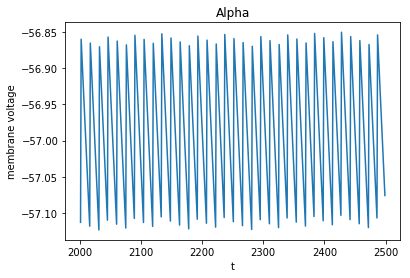

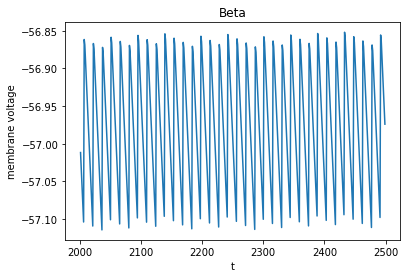

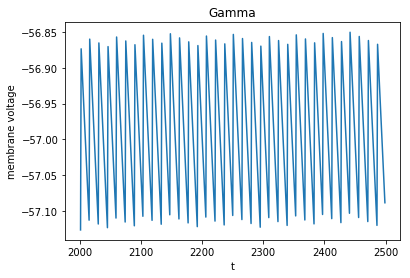

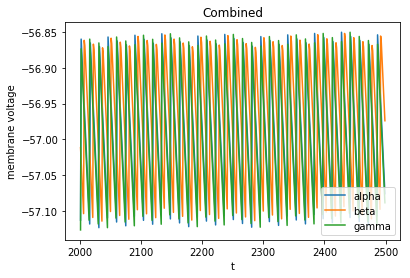

In [7]:
# plot membrane potential
dmm_alpha = nest.GetStatus(multimeter_alpha)[0]
Vms_alpha = dmm_alpha["events"]["V_m"][warmup:]
ts_alpha = dmm_alpha["events"]["times"][warmup:]

dmm_beta = nest.GetStatus(multimeter_beta)[0]
Vms_beta = dmm_beta["events"]["V_m"][warmup:]
ts_beta = dmm_beta["events"]["times"][warmup:]

dmm_gamma = nest.GetStatus(multimeter_gamma)[0]
Vms_gamma = dmm_gamma["events"]["V_m"][warmup:]
ts_gamma = dmm_gamma["events"]["times"][warmup:]

pylab.figure(1)
pylab.plot(ts_alpha, Vms_alpha)
pylab.xlabel("t")
pylab.ylabel("membrane voltage")
pylab.title("Alpha")
pylab.show()

pylab.figure(2)
pylab.plot(ts_beta, Vms_beta)
pylab.xlabel("t")
pylab.ylabel("membrane voltage")
pylab.title("Beta")
pylab.show()

pylab.figure(3)
pylab.plot(ts_gamma, Vms_gamma)
pylab.xlabel("t")
pylab.ylabel("membrane voltage")
pylab.title("Gamma")
pylab.show()

pylab.figure(4)
pylab.plot(ts_alpha, Vms_alpha)
pylab.plot(ts_beta, Vms_beta)
pylab.plot(ts_gamma, Vms_gamma)
pylab.legend(["alpha", "beta", "gamma"])
pylab.xlabel("t")
pylab.ylabel("membrane voltage")
pylab.title("Combined")
pylab.show()

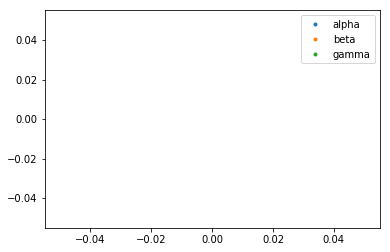

In [8]:
# plot spike occurrances (does not really work for hh neurons yet)
dSD_alpha = nest.GetStatus(spikedetector_alpha, keys="events")[0]
evs_alpha = dSD_alpha["senders"]
ts_sd_alpha = dSD_alpha["times"]

dSD_beta = nest.GetStatus(spikedetector_beta, keys="events")[0]
evs_beta = dSD_beta["senders"]
ts_sd_beta = dSD_beta["times"]

dSD_gamma = nest.GetStatus(spikedetector_gamma, keys="events")[0]
evs_gamma = dSD_gamma["senders"]
ts_sd_gamma = dSD_gamma["times"]

pylab.figure(2)
pylab.plot(ts_sd_alpha, evs_alpha, ".")
pylab.plot(ts_sd_beta, evs_beta, ".")
pylab.plot(ts_sd_gamma, evs_gamma, ".")
pylab.legend(["alpha", "beta", "gamma"])
pylab.show()